In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [24]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import os
import glob
import sys


current_dir = os.getcwd()
# Get the grandparent directory (two levels up)
grandparent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
# Add the grandparent directory to sys.path
sys.path.insert(0, grandparent_dir)

from utility import fluvial_dataloader
from viz import show_generated_samples

## setup model

In [13]:
from diffusers import RePaintPipeline, RePaintScheduler
generator = torch.Generator(device="cuda").manual_seed(0)

# Create the network
net = UNet2DModel(
    sample_size=(64,64),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Load the model
model_path = '/scratch1/junjieyu/Diffusion_Model/DDPM/Geo_examples/monitor_channel/model_80.pt'
net.load_state_dict(torch.load(model_path))

# load dataset
train_dataloader = fluvial_dataloader(batch_size = 16)

In [37]:
sample.shape

torch.Size([16, 1, 64, 64])

## Compare training and generated images

  0%|          | 0/10 [00:00<?, ?it/s]

(64, 64, 64, 1)


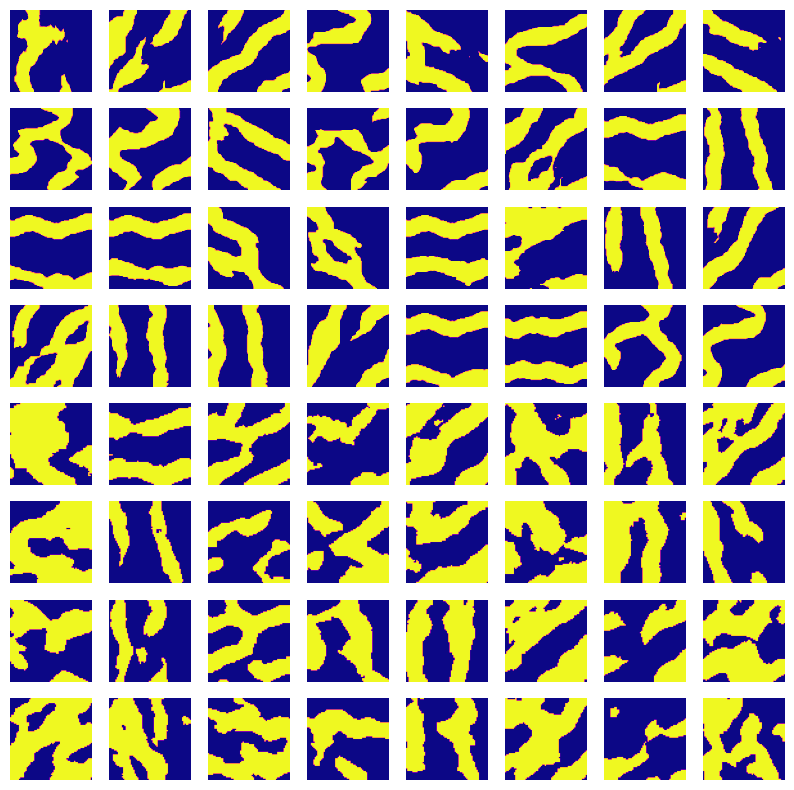

In [46]:
from diffusers import DDPMPipeline, DDPMScheduler
from viz import compare_generated_samples

scheduler = DDPMScheduler()
gen_pipe = DDPMPipeline(unet = net, scheduler = scheduler)

train_dataloader = fluvial_dataloader(batch_size = 32)
sample = next(iter(train_dataloader))
sample = sample.permute(0,2,3,1)

gen_images = gen_pipe(
        batch_size=32,
        generator=torch.manual_seed(1),
        output_type = 'numpy',
        num_inference_steps =10
    ).images

compare_generated_samples(sample.cpu(), gen_images, ncols = 8, binary = True)

# Flexible Dimension Generation

by using U-net architecture without any flatten layer, the network can generate different realizations of different dimension

In [9]:
# load the model
net = UNet2DModel(
    sample_size=(64,64),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Load the model
model_path = '/scratch1/junjieyu/Diffusion_Model/DDPM/Geo_examples/monitor_channel/model_80.pt'
net.load_state_dict(torch.load(model_path))
#

<All keys matched successfully>

In [ ]:
dimensions_set = [
    (64, 64),
    (128, 128),
    (32, 32),
    (20, 60),
    (60, 20)
]

fig, axs = plt.subplots(1, len(dimensions_set), figsize=(20, 5))
for dim, ax in zip(dimensions_set, axs):
    n_steps = 40
    x = torch.rand(64, 1, dim[0], dim[1]).to(device)
    for i in range(n_steps):
        noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
        with torch.no_grad():
            pred = net(x, 0).sample
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor
    # shift value from [-1, 1] to [0, 1]
    x = (x + 1) / 2
    ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(0, 1), 
                                              nrow=8,
                                              padding=1, pad_value=1)[0], cmap='plasma')
    ax.axis('off')
    ax.set_title(f'{dim[0]}x{dim[1]}')
fig.savefig('generated_channel_samples_different_dimensions.png', dpi=300, bbox_inches='tight')

In [ ]:
x = torch.rand(64, 1, 64,64).to(device)
pred = net(x, 0).sample
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(0, 1),
                                                nrow=8,
                                                padding=1, pad_value=1)[0], cmap='plasma')
ax1.set_title('Input')
ax1.axis('off')
ax2.imshow(torchvision.utils.make_grid(pred.detach().cpu().clip(0, 1),
                                                nrow=8,
                                                padding=1, pad_value=1)[0], cmap='plasma')
ax2.set_title('Output')


# Repaint performance


## setup the model

In [3]:
from diffusers import RePaintPipeline, RePaintScheduler
generator = torch.Generator(device="cuda").manual_seed(0)\

# Create the network
net = UNet2DModel(
    sample_size=(64,64),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Load the model
model_path = '/scratch1/junjieyu/Diffusion_Model/DDPM/Geo_examples/monitor_channel/model_80.pt'
net.load_state_dict(torch.load(model_path))

# load dataset
train_dataloader = fluvial_dataloader(batch_size = 16)

/home1/junjieyu/.conda/envs/DDPM/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## setup repaint pipeline

In [4]:
repaint_scheduler = RePaintScheduler()
repaint_pipe = RePaintPipeline(net, scheduler=repaint_scheduler)
repaint_pipe = repaint_pipe.to("cuda")


## repaint with random pixel mask

  0%|          | 0/10 [00:00<?, ?it/s]

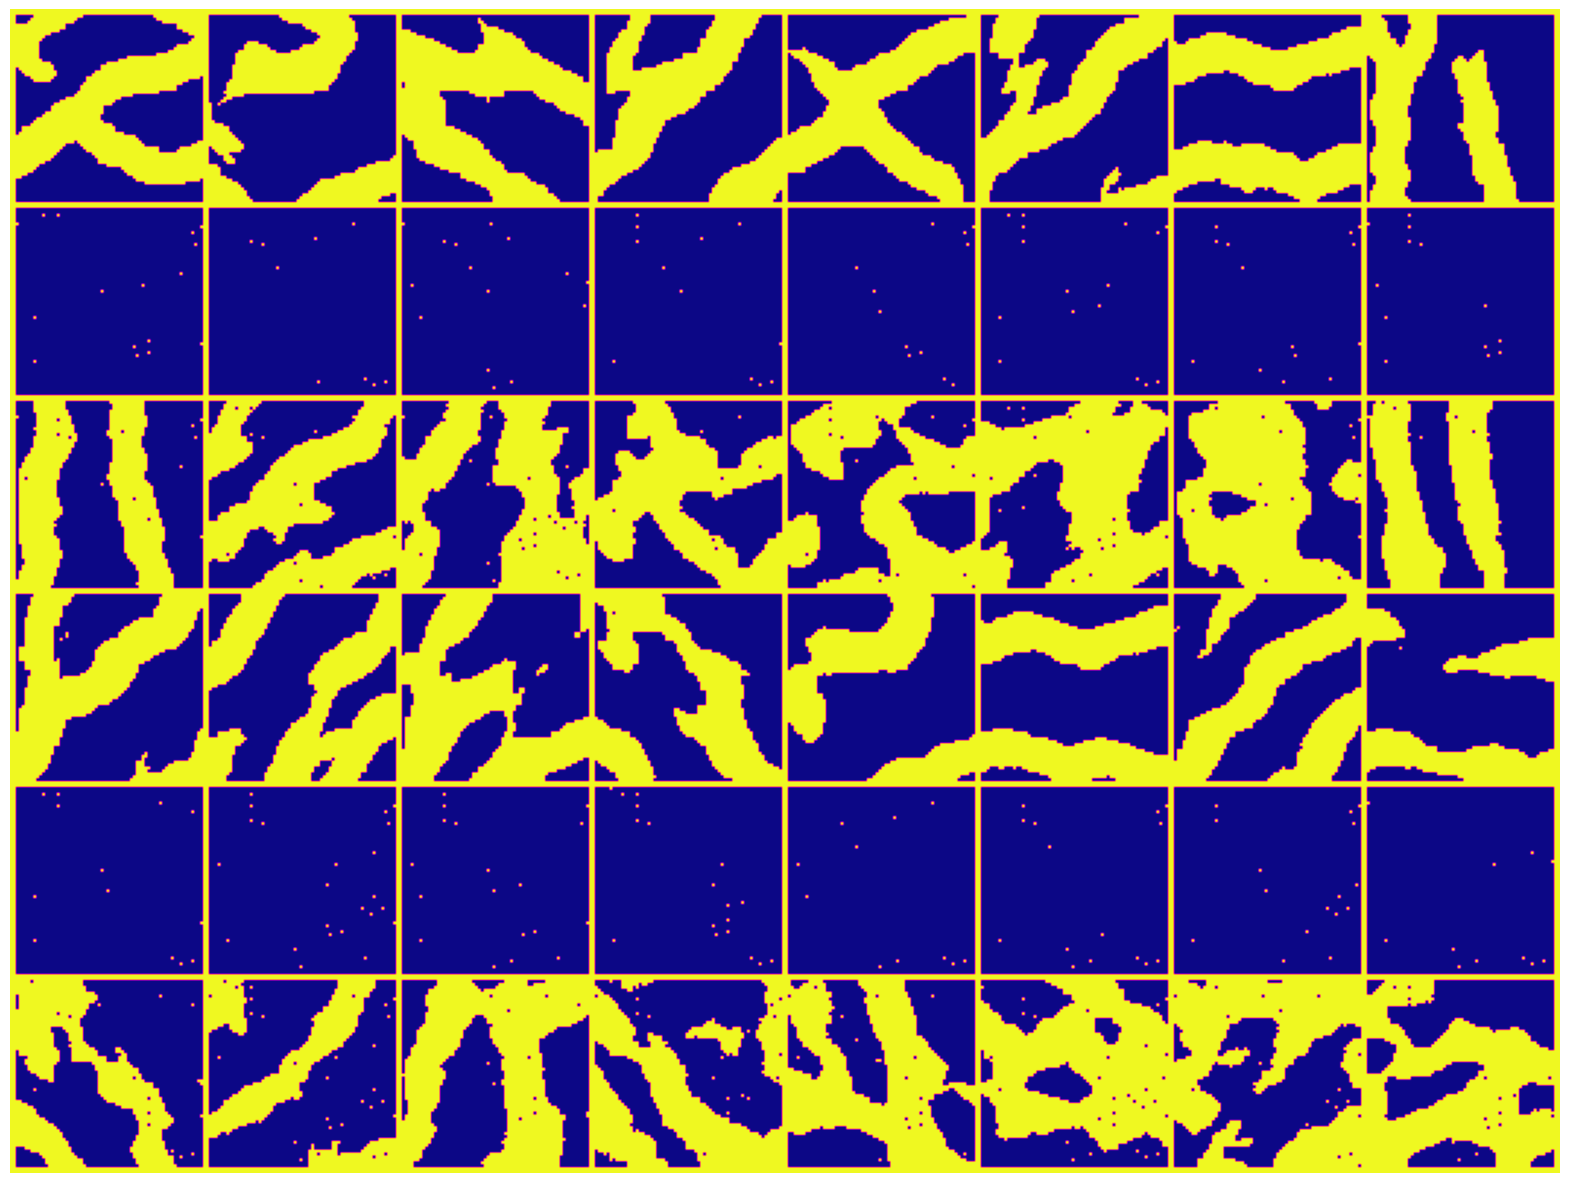

In [8]:
from utility import get_penetrate_mask, get_random_pixel_mask
from viz import compare_repaint

shape = (64,64)
mask = get_random_pixel_mask(shape, 0.01)
mask = mask.to(device)

sample = next(iter(train_dataloader))
sample = sample.to(device)

#
repaint_images = repaint_pipe(
            image=sample,
            mask_image=mask,
            num_inference_steps=10,
            eta=0,
            jump_length=20,
            jump_n_sample=30,
            generator=generator,
            output_type = 'numpy'
            ).images
repaint_images = torch.tensor(repaint_images)
from viz import compare_repaint
compare_repaint(repaint_images, sample, mask,binary=True)

## repaint with raypath

In [30]:
# create mask (for plume dataset)
shape = (1,64,64)
receivers = [(0,i*30,64) for i in range(2)]
senders = [(0,0,64),(1,63,64)]
mask = get_penetrate_mask(senders, receivers, shape = shape)
mask = mask.to(device)

sample = next(iter(train_dataloader))
sample = sample.to(device)
repaint_images = repaint_pipe(
            image=sample,
            mask_image=mask,
            num_inference_steps=500,
            eta=1,
            jump_length=10,
            jump_n_sample=5,
            generator=generator,
            output_type = 'numpy'
            ).images
repaint_images = torch.tensor(repaint_images)
from viz import compare_repaint
compare_repaint(repaint_images, sample, mask,binary=True)

NameError: name 'patched_mask' is not defined

## patch based mask

  0%|          | 0/3620 [00:00<?, ?it/s]

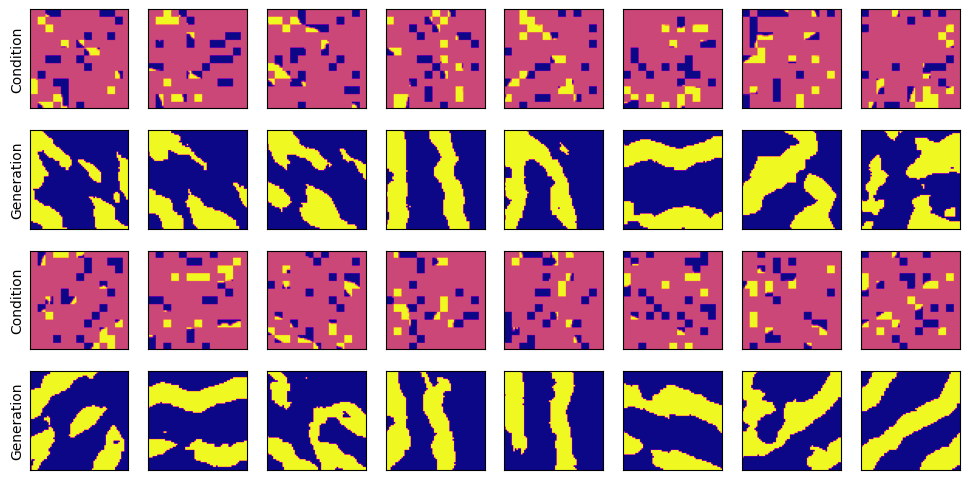

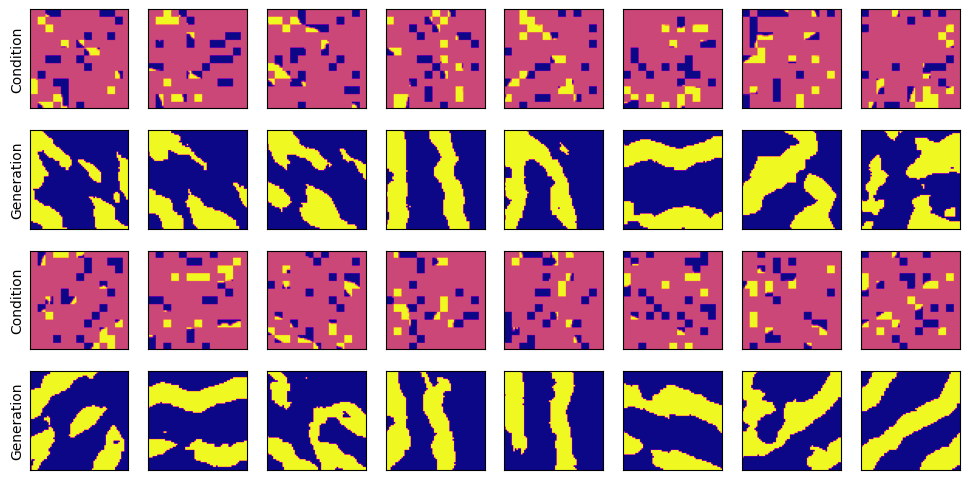

In [7]:
from utility import patched_mask

bs = 16
# create a batch of mask
shape = (64,64)
batch_mask = torch.zeros((bs,1,shape[0],shape[1]))
for i in range(bs):
    batch_mask[i] = patched_mask(shape, 0.2, patch_size = (5,5))
batch_mask = batch_mask.to(device)

sample = next(iter(train_dataloader))
sample = sample.to(device)
repaint_images = repaint_pipe(
            image=sample,
            mask_image=batch_mask,
            num_inference_steps=200,
            eta=0,
            jump_length=10,
            jump_n_sample=10,
            generator=generator,
            output_type = 'numpy'
            ).images

repaint_images = torch.tensor(repaint_images)
repaint_images = repaint_images * 2 -1
from viz import show_conditional_generation
conditional_images = sample * batch_mask
show_conditional_generation(conditional_images.cpu(), repaint_images.cpu(), ncols=8, binary = True)

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/10940 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

/scratch1/junjieyu/Diffusion_Model/viz.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows*2, ncols, figsize=(12,6))


  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/5340 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

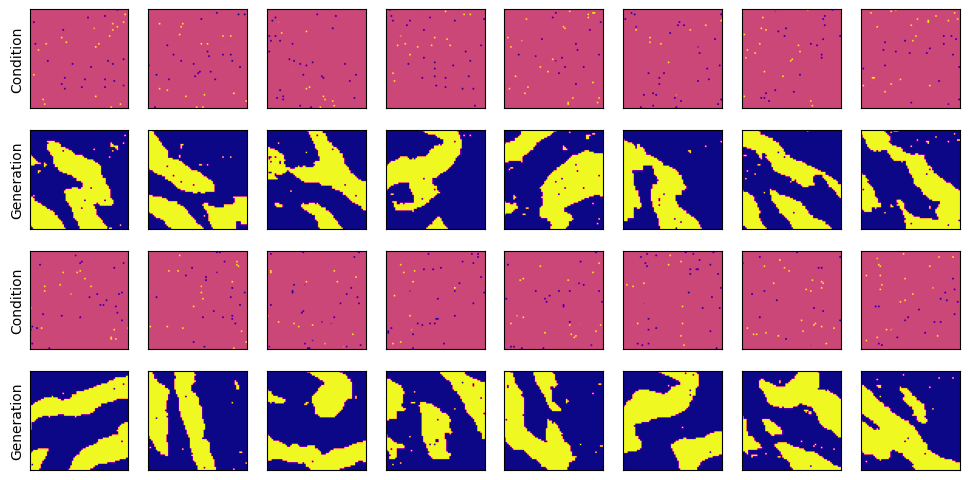

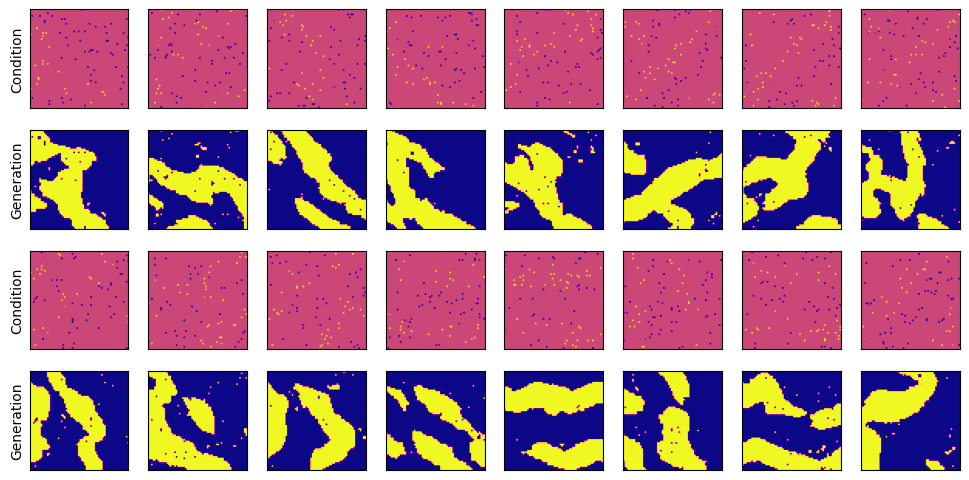

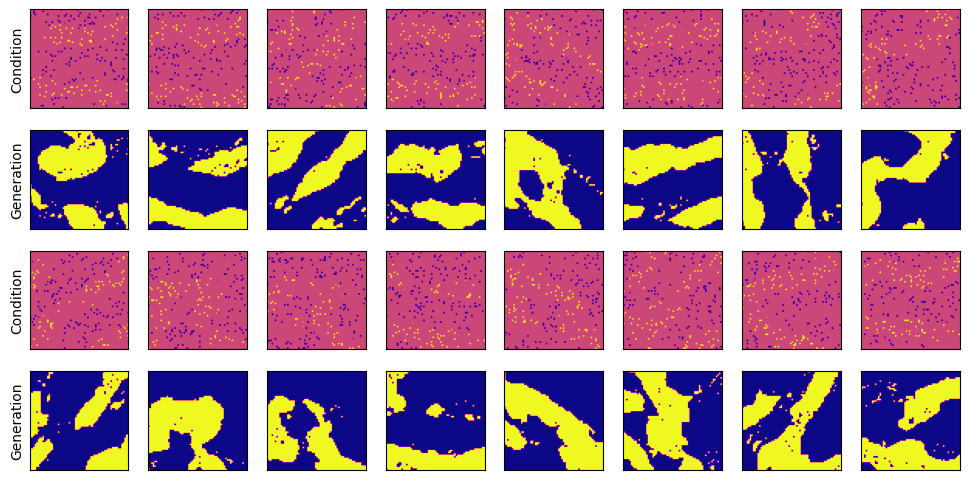

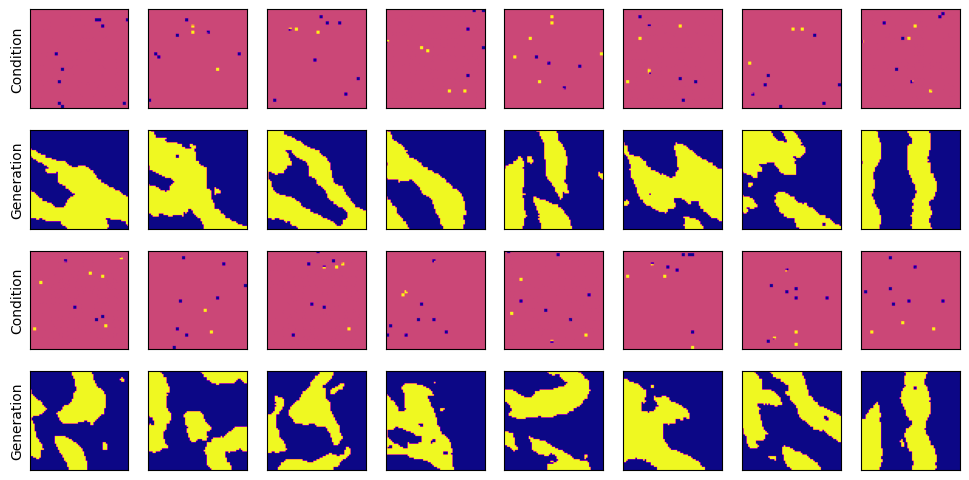

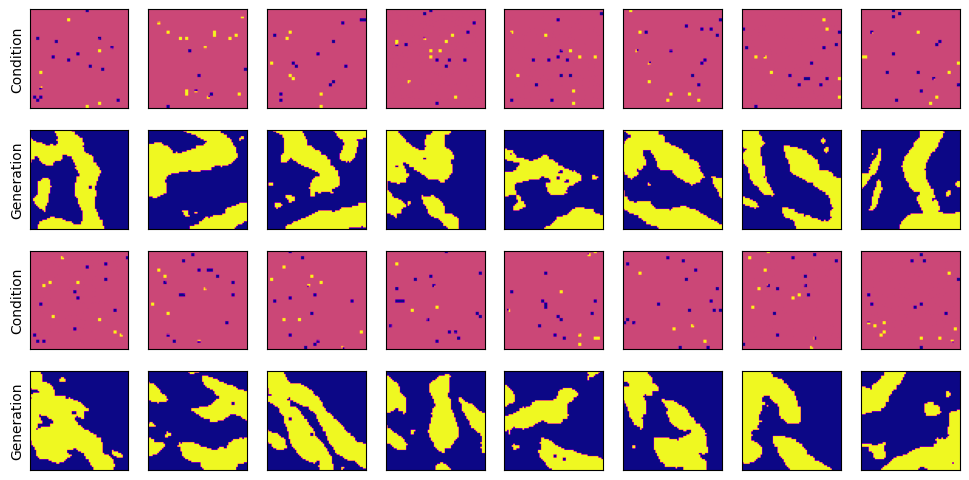

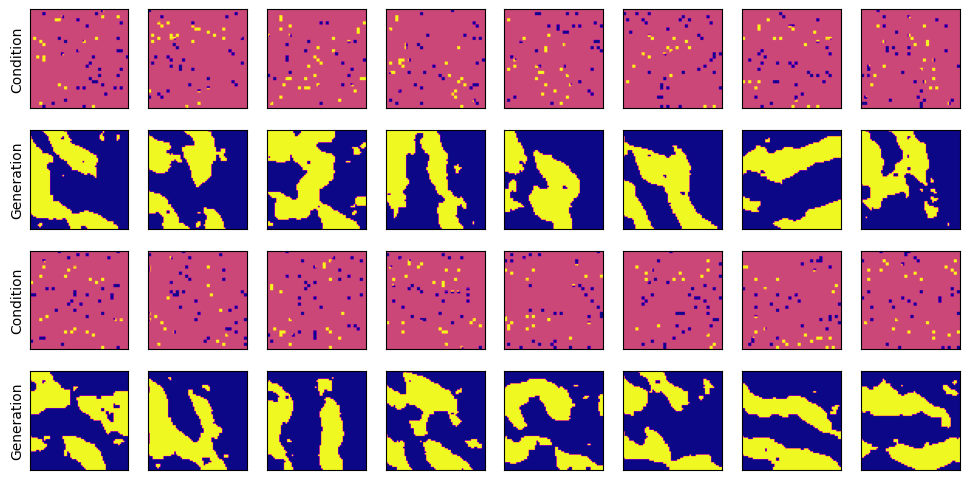

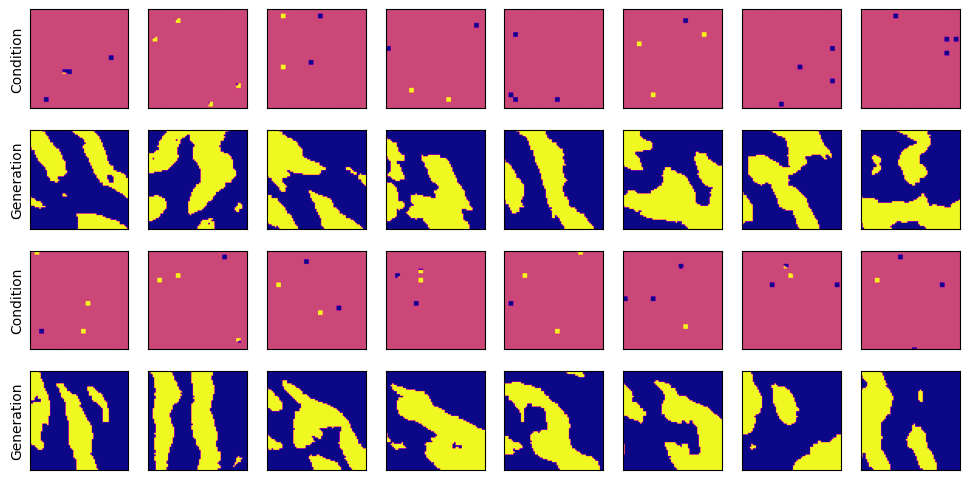

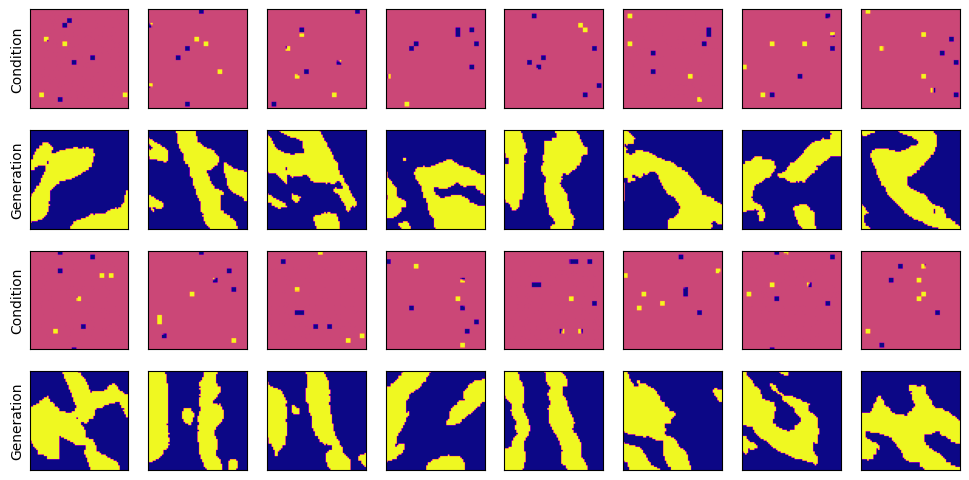

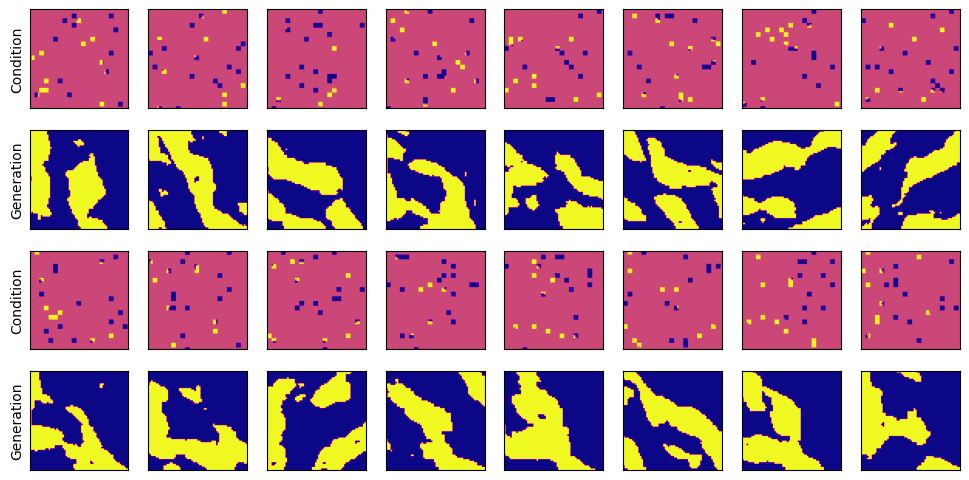

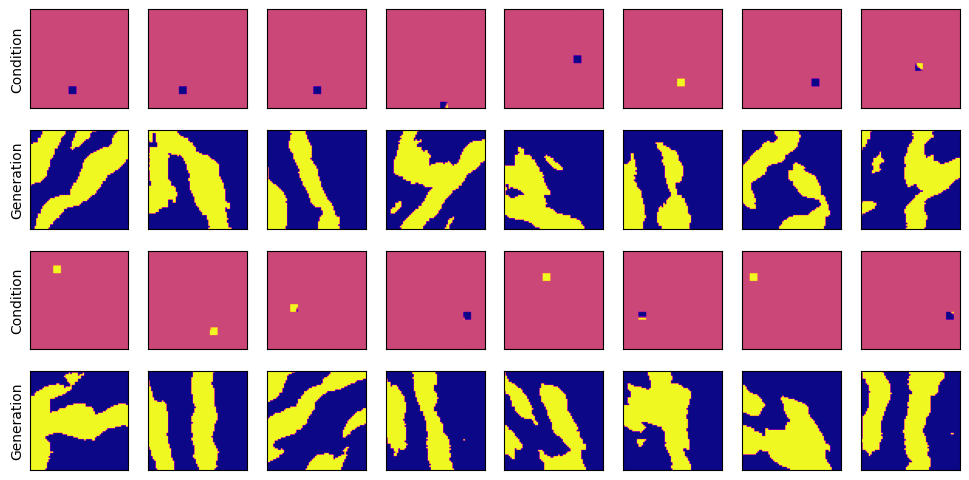

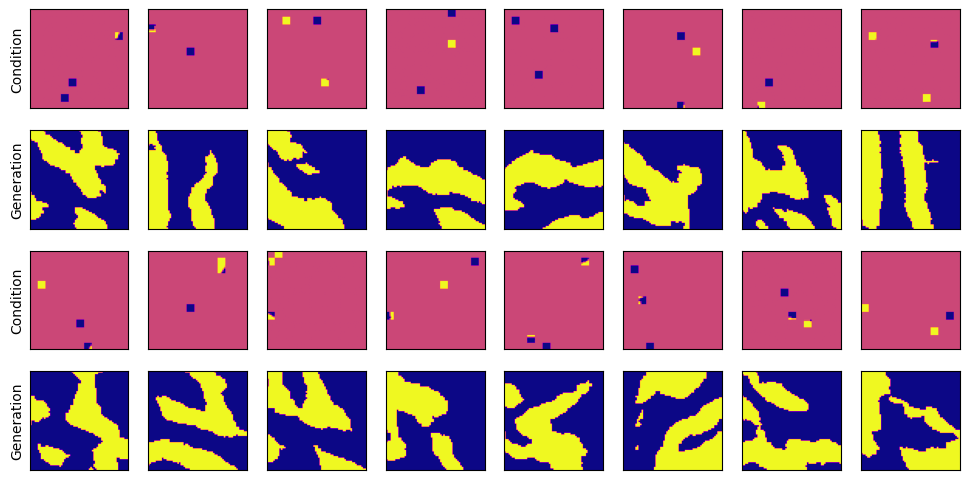

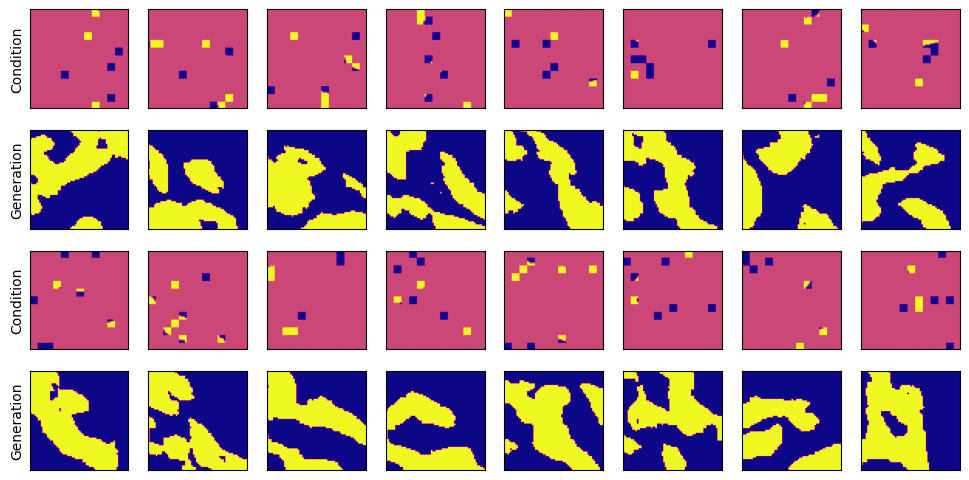

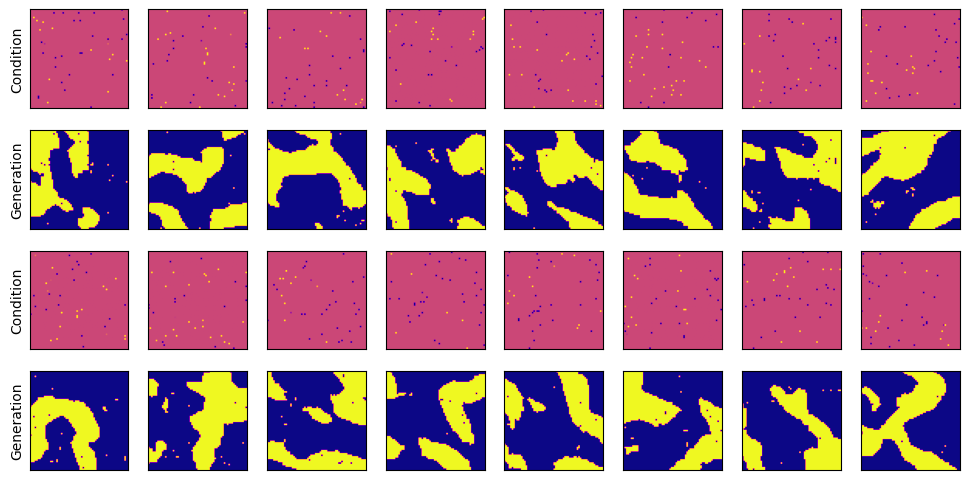

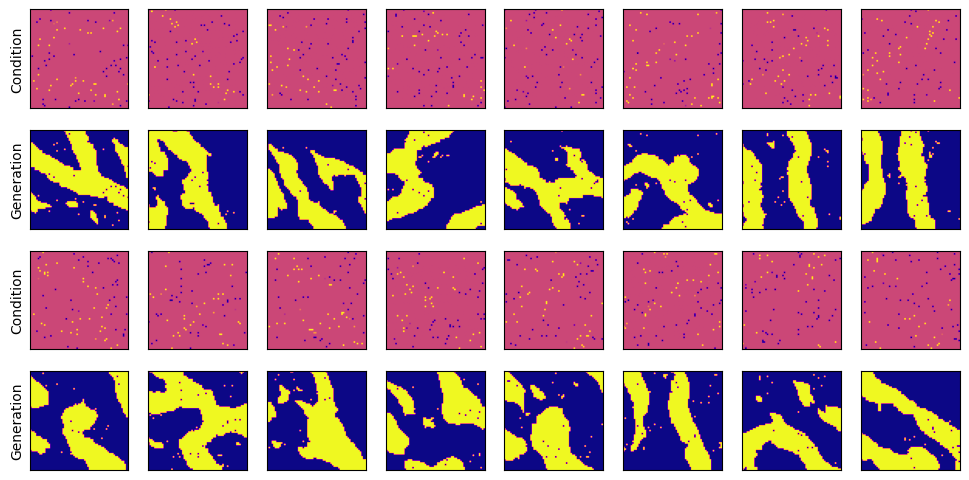

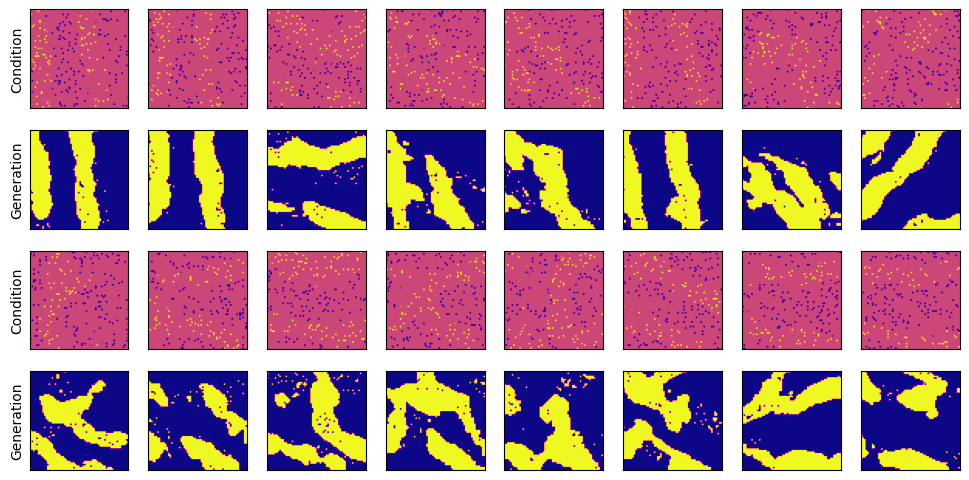

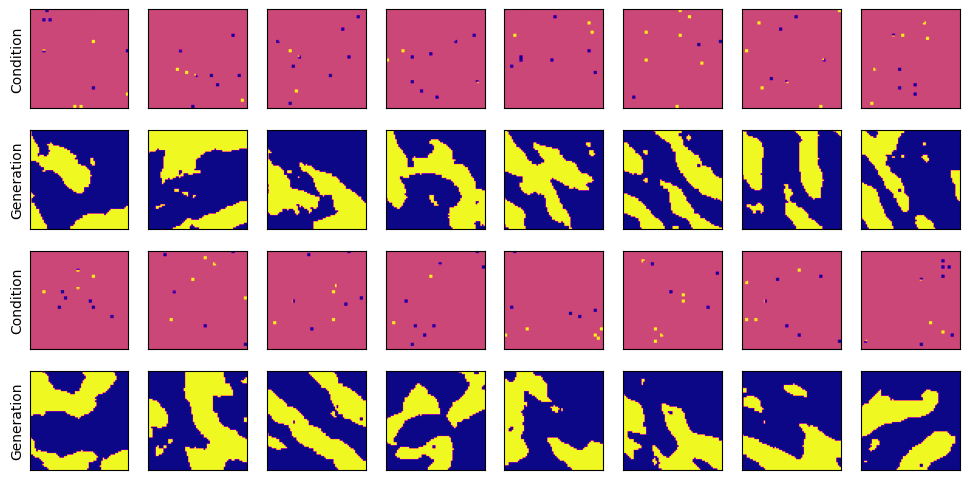

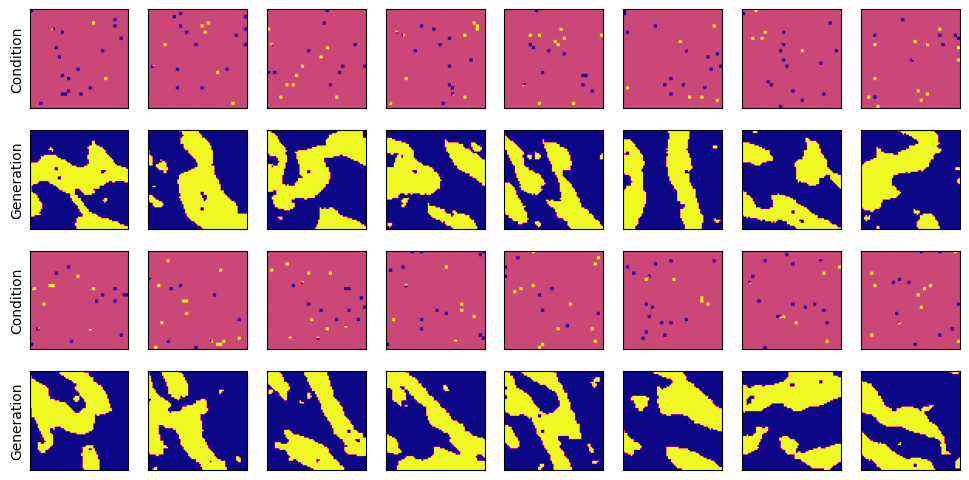

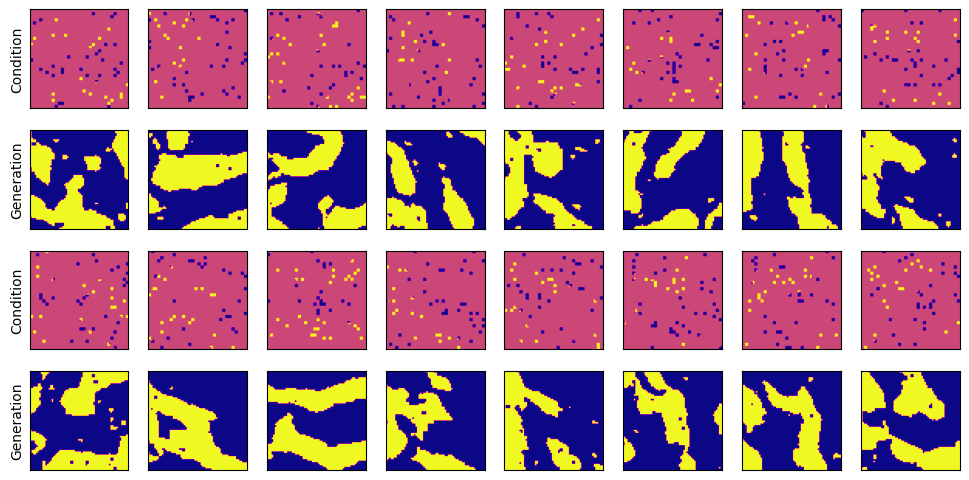

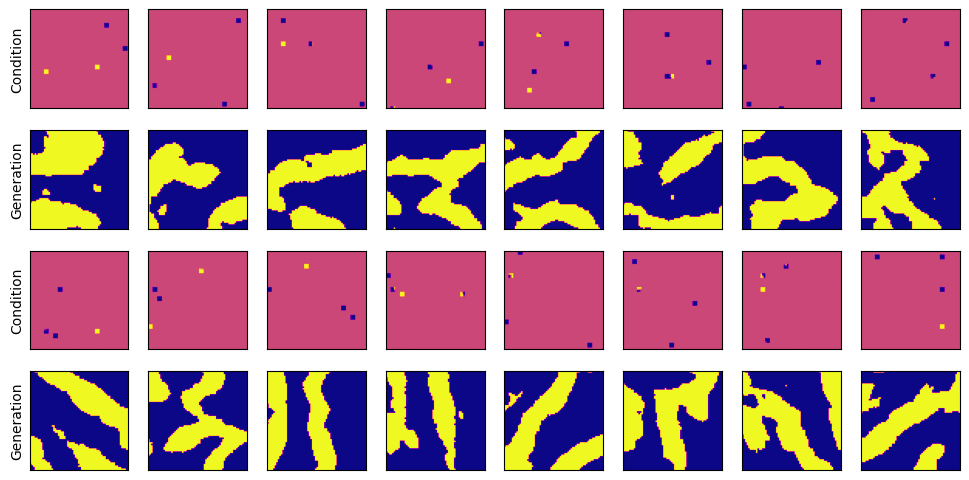

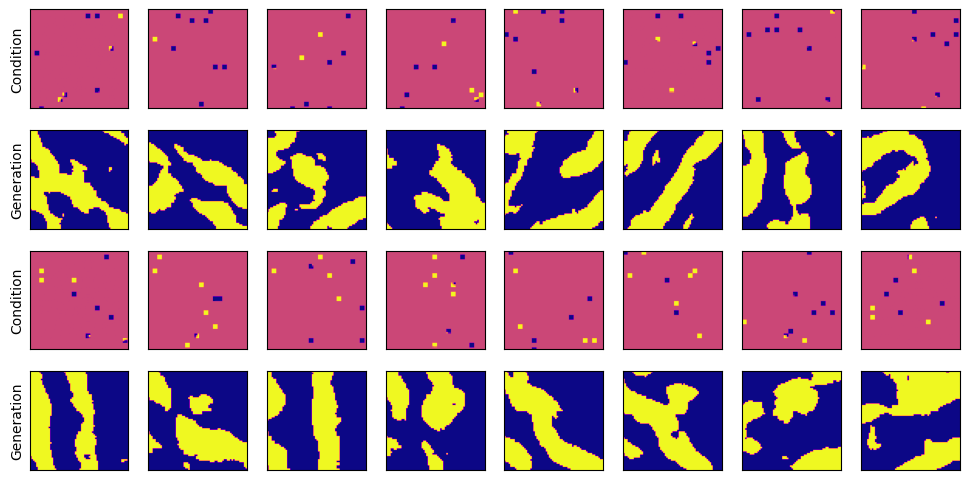

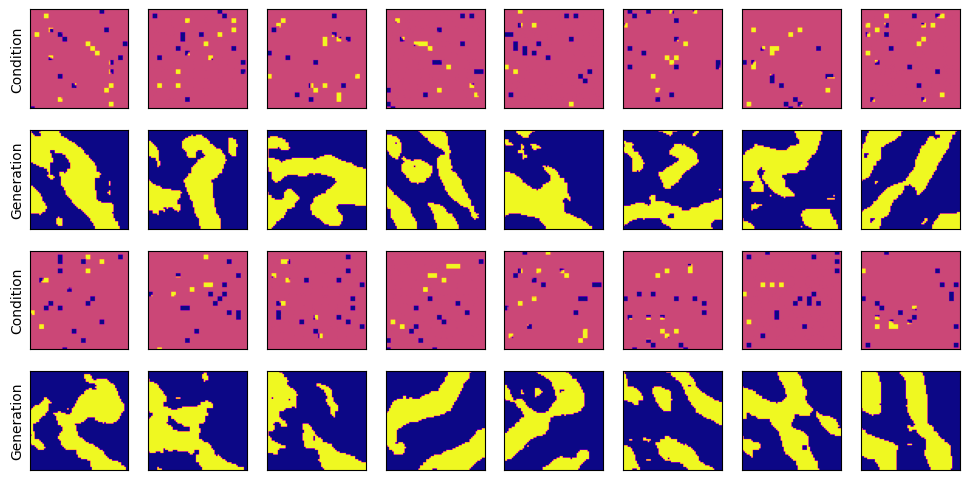

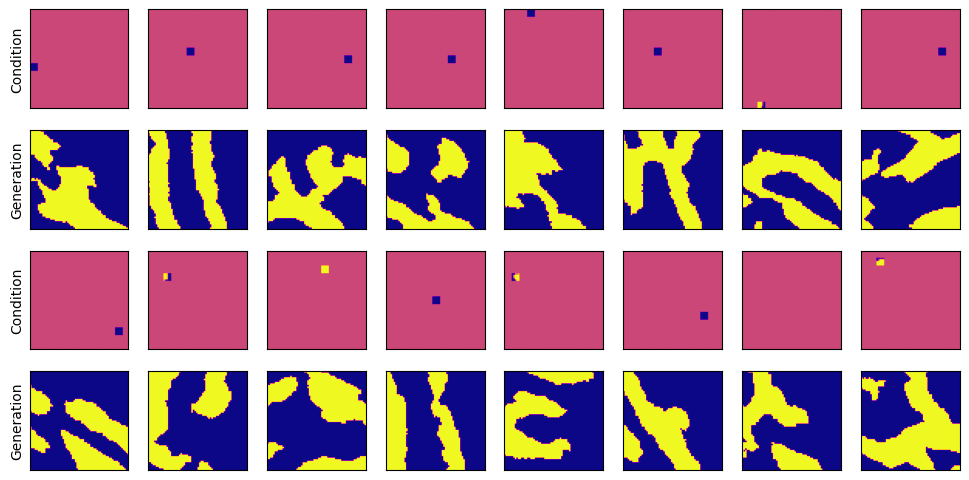

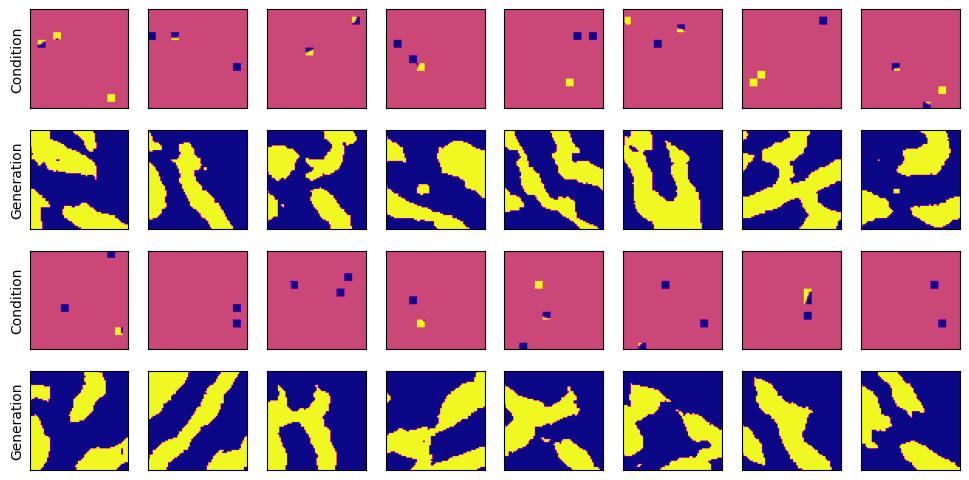

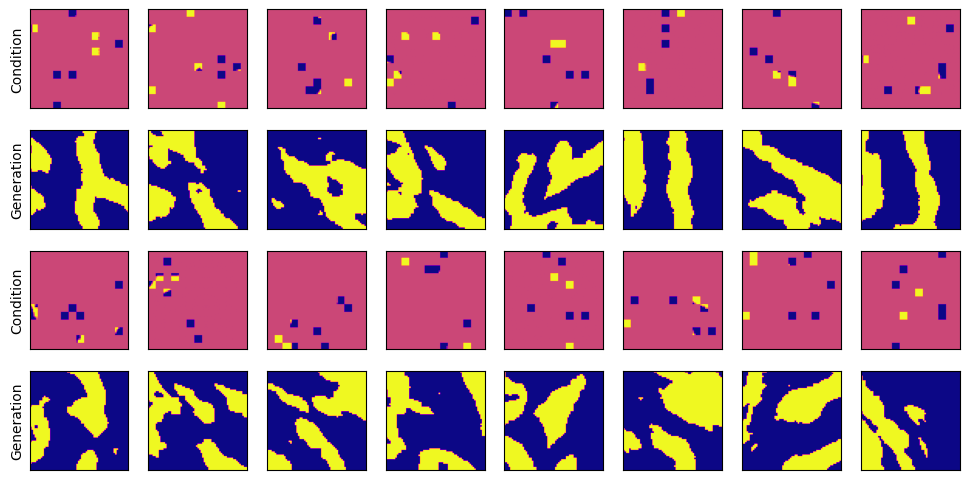

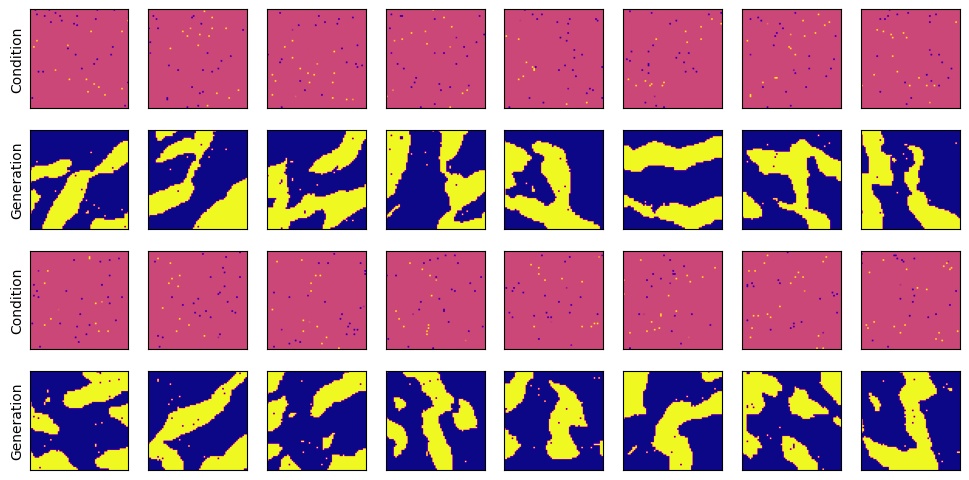

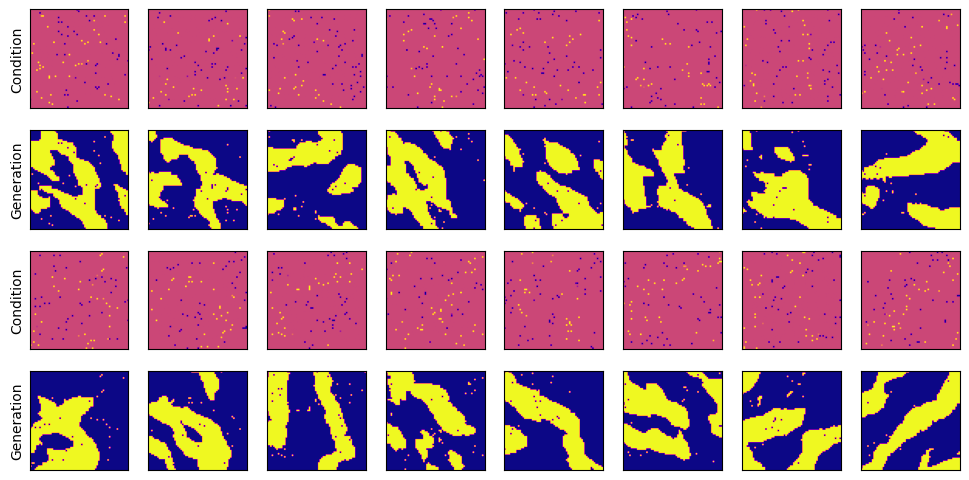

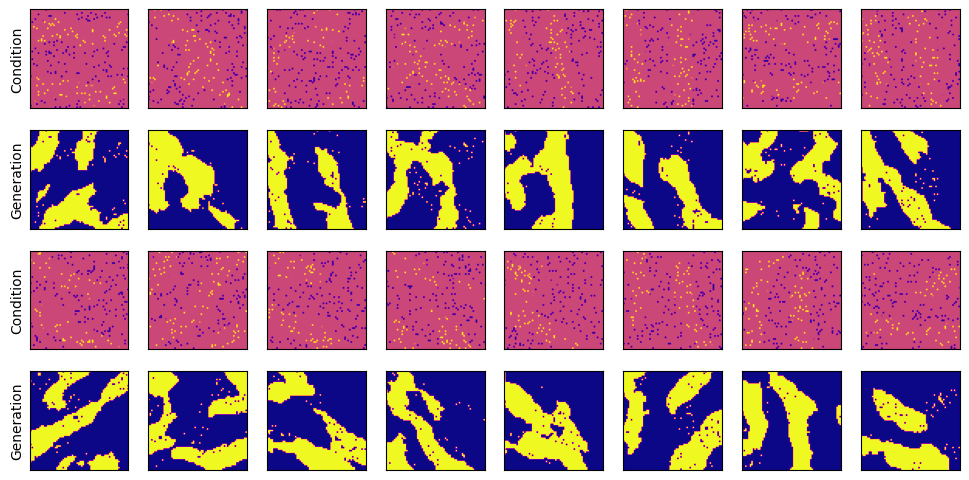

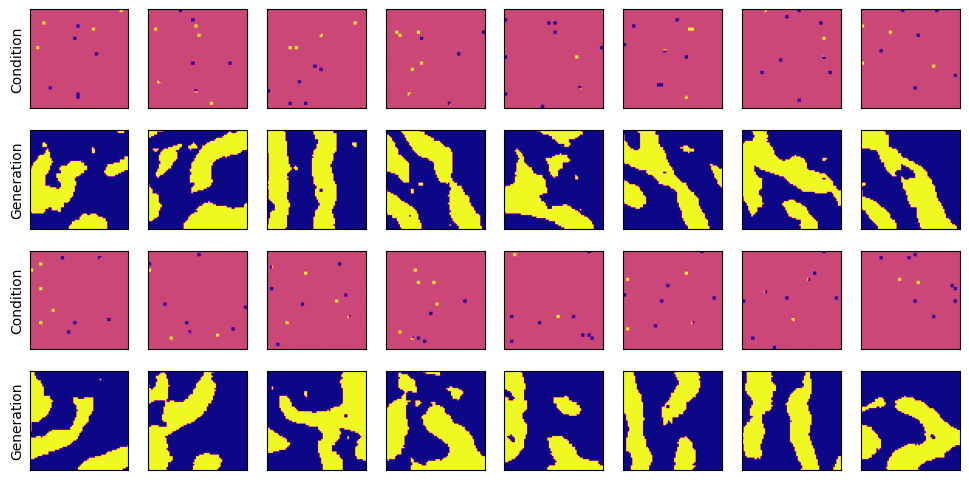

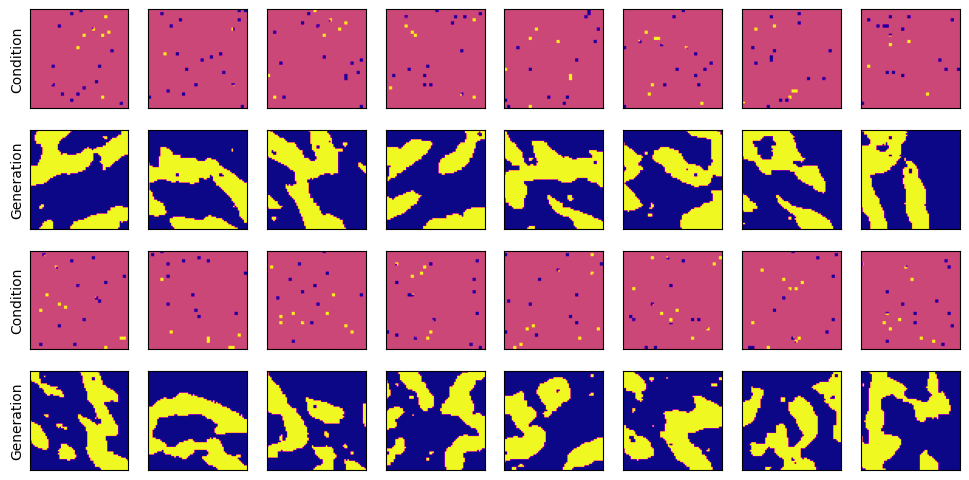

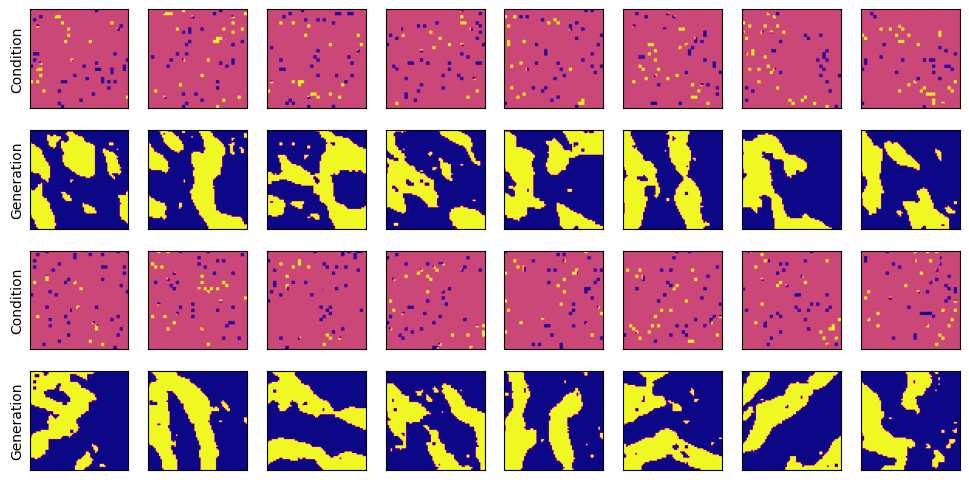

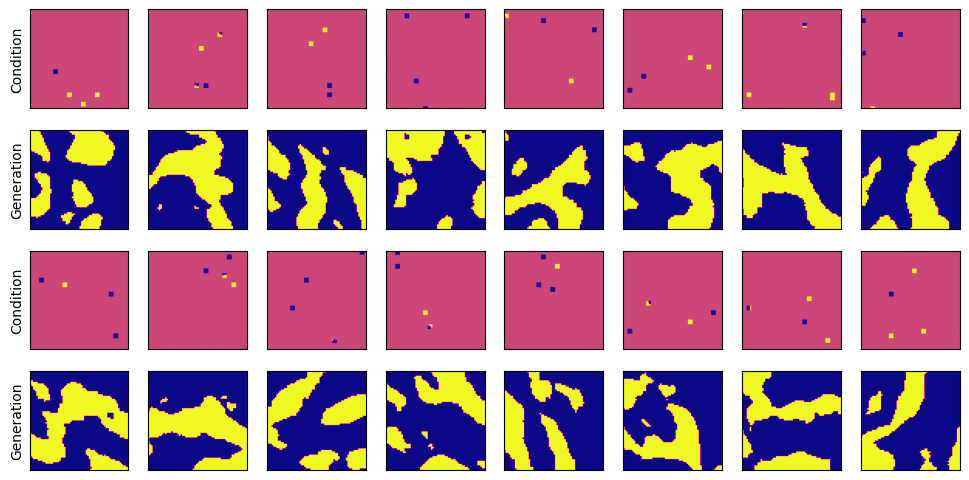

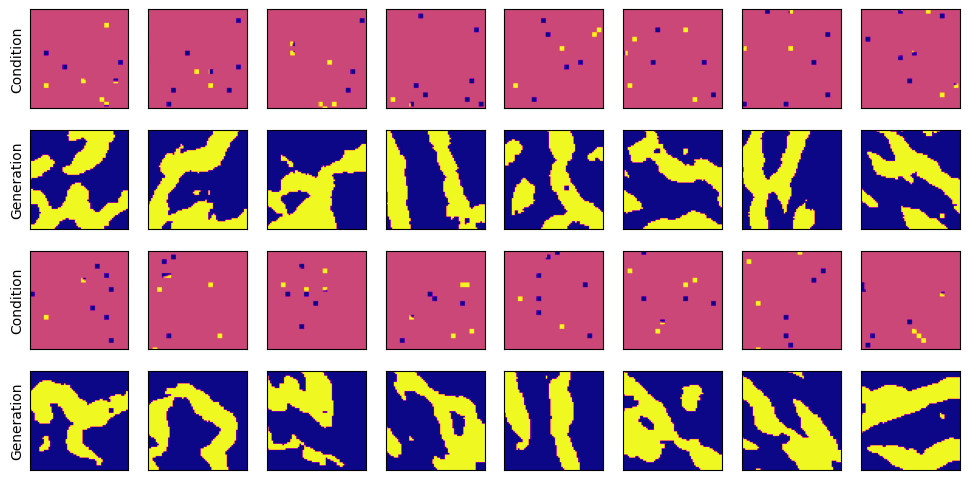

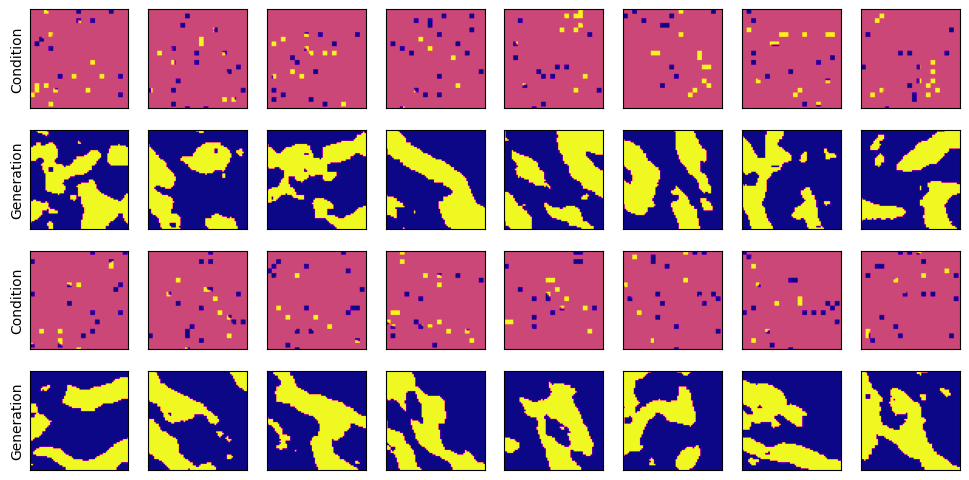

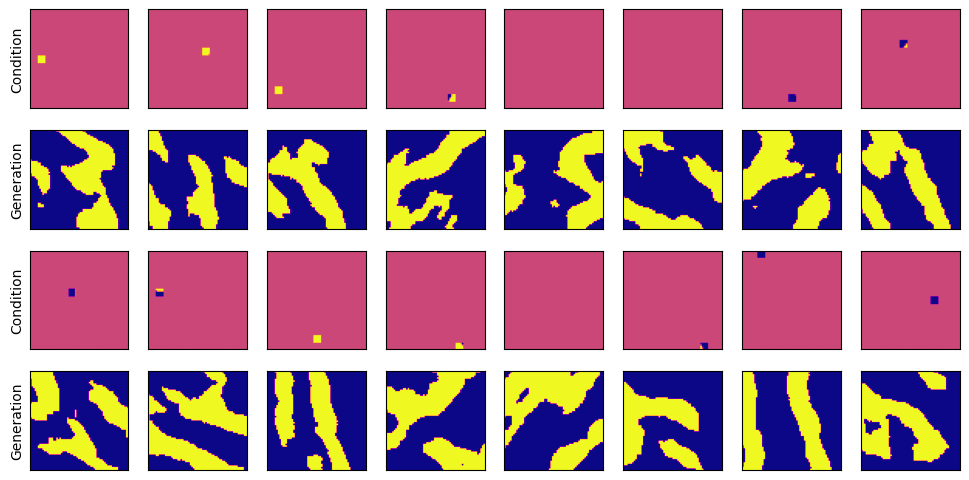

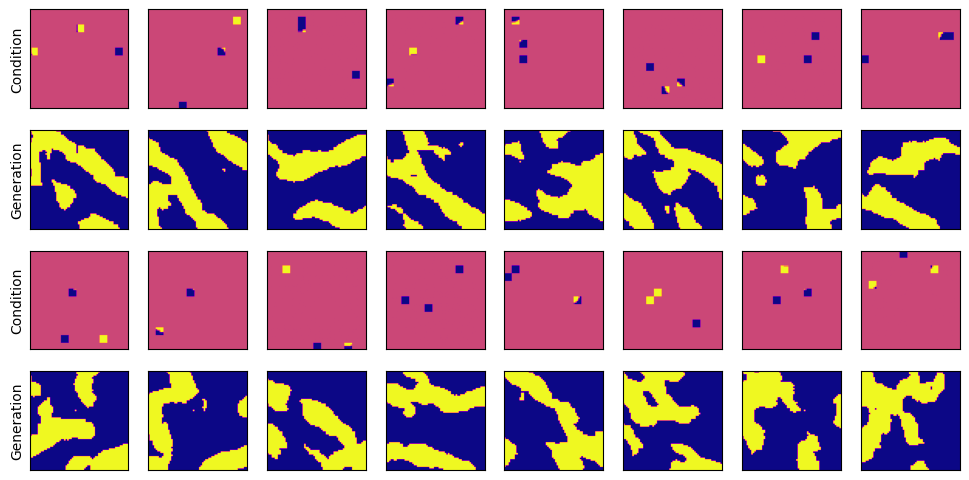

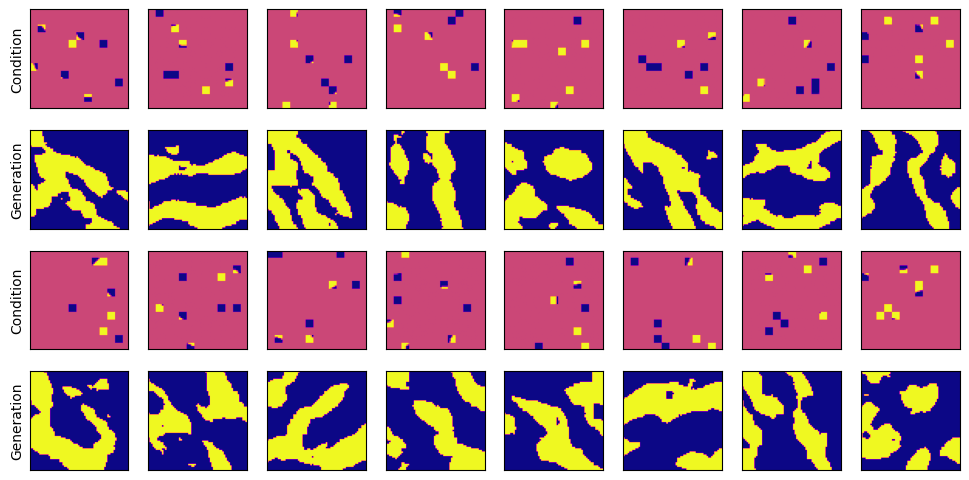

In [22]:
# for comprehensive test
# create a folder for saving the results
import os
import shutil
repaint_patch_folder = 'repaint_patch_folder'
if not os.path.exists(repaint_patch_folder):
    os.makedirs(repaint_patch_folder)
else:
    shutil.rmtree(repaint_patch_folder)
    os.makedirs(repaint_patch_folder)

jump_n_candidates = [3020,10,5]
patch_size_candidates = [(1,1),(2,2),(3,3),(5,5)]
mask_ratio_candidates = [0.01, 0.02, 0.05]
for jump_n in jump_n_candidates:
    for patch_size in patch_size_candidates:
        for mask_ratio in mask_ratio_candidates:
            shape = (64,64)
            batch_mask = torch.zeros((bs,1,shape[0],shape[1]))
            for i in range(bs):
                batch_mask[i] = patched_mask(shape,mask_ratio, patch_size = patch_size)
            batch_mask = batch_mask.to(device)
            sample = next(iter(train_dataloader))
            sample = sample.to(device)
            repaint_images = repaint_pipe(
                        image=sample,
                        mask_image=batch_mask,
                        num_inference_steps=300,
                        eta=0,
                        jump_length=20,
                        jump_n_sample=jump_n,
                        generator=generator,
                        output_type = 'numpy'
                        ).images
            repaint_images = torch.tensor(repaint_images)
            repaint_images = repaint_images * 2 -1
            from viz import show_conditional_generation
            conditional_images = sample * batch_mask
            fig = show_conditional_generation(conditional_images.cpu(), repaint_images.cpu(), ncols=8, binary = True)
            fig.savefig(f'{repaint_patch_folder}/jump_n_{jump_n}_patch_size_{patch_size}_mask_ratio_{mask_ratio}.png')



## repaint with noise sample

  0%|          | 0/10 [00:00<?, ?it/s]

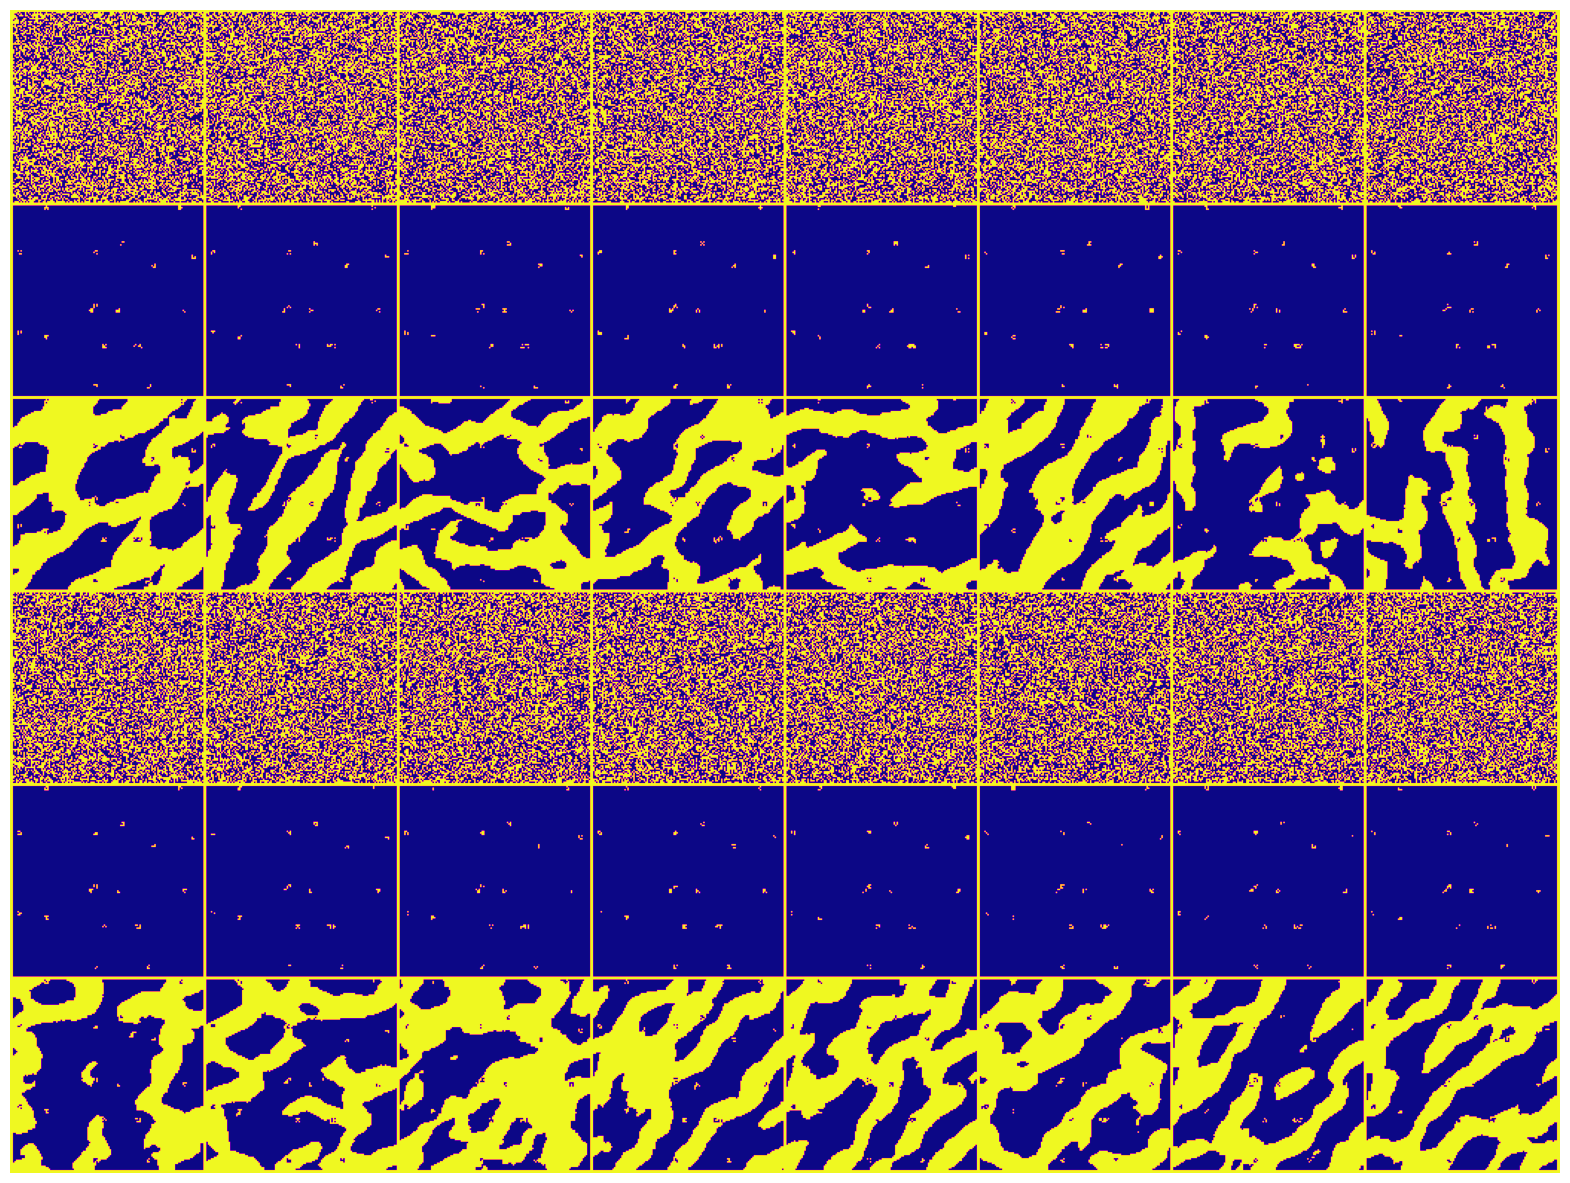

In [16]:
from utility import patched_mask


shape = (128,128)
mask = patched_mask(shape, 0.01, patch_size = (3,3))
mask = mask.to(device)

bs = 16
sample  = torch.randint(0, 2, (bs, 1, shape[0], shape[1]), dtype=torch.uint8).float().to(device)

repaint_images = repaint_pipe(
            image=sample,
            mask_image=mask,
            num_inference_steps=10,
            eta=0,
            jump_length=10,
            jump_n_sample=10,
            generator=generator,
            output_type = 'numpy'
            ).images

repaint_images = torch.tensor(repaint_images)
from viz import show_conditional_generation
show_conditional_generation(

In [11]:

noise_batch = torch.randint(0, 2, (16, 1, 64, 64), dtype=torch.uint8).float().to(device)

In [17]:
sample = next(iter(train_dataloader))
sample = sample.to(device)

tensor([[[[ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [-1.0000, -0.9966, -1.0842,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0258, -0.7977,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0960, -0.0853,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000